In [31]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import doctest

In [79]:
def sample(img:np.ndarray, n_draws:int = 1_000, figsize:tuple[int,int] = (10,4), dot_size:int = 1, title:str = 'sampled image',cmap:str = 'coolwarm', alpha:float = 1.0, cbar:bool = True) -> None:
    """ 
    A method which draws randomly points form a 2D probability distribution defined by the input image. 
    The sample points are then displayed in a scatter plot in the color representing their probability (using a spedified colormap).

    :param img: gray scale image representing the probability distribution
    :type img: np.darray

    :param n_draws: number of draws (default 1_000)
    :type n_draws: int

    :param figsize: figure size (default (10,4))
    :type figsize: tuple[int,int]

    :param dot_size: size of the marker in scatter plot
    :type dot_size: int

    :param title: title (default 'sampled image')
    :type title: str

    :param cmap: colormap (default 'coolwarm')
    :type cmap: str

    :param alpha: transparancy/alpha-value (default 1.0)
    :type alpha: float

    :param cbar: colorbar (default True)
    :type cbar: bool

    :returns: scatter plot of the randomly drawn samples
    :rtype: None

    Examples
    --------
    .. code-block:: python
        :linenos:

        >>> import numpy as np
        >>> import matplotlib.pyplot as plt

        >>> bar = np.abs(np.random.standard_normal(size=(100,100)))
        >>> bar /= bar.sum()

        >>> sample(bar,n_draws=1_000,dot_size=10,title='test sampling from 2D Gaussian')

    """
    # DIMENSIONS
    n, m = img.shape

    img_ = img.copy()

    img_ = img_.astype(float)
    img_ /= img_.sum() # normalise
    img_vec = img_.flatten() # flatten
    cdf = img_vec.cumsum() # compute CDF

    # BUILD MAP MATRIX <-> VECTOR
    mymap = np.array([(col, row) for row in range(n) for col in range(m)]) # (*) order to preserve orientation of img

    # SAMPLE
    r = np.random.uniform(0, 1, size=n_draws)  # draw all samples at once
    idx = np.searchsorted(cdf, r)  # binary search to find indices corresponding to CDF

    samples = mymap[idx]
    colors = [img[col,row] for row,col in samples] # note order of col, row due to order in (*)
    
    # PLOTTING
    fig,ax = plt.subplots(figsize=figsize)
    plot = ax.scatter(samples[:,0],samples[:,1],c=colors,s=dot_size,cmap=cmap,alpha=alpha)
    plt.gca().invert_yaxis()
    plt.gca().set_aspect(1)
    if cbar:
        colorbar = plt.colorbar(plot)
        colorbar.formatter.set_powerlimits((0, 0))
        colorbar.ax.set_ylabel('probabilities', rotation=270,labelpad=20)
    plt.title(title)
   

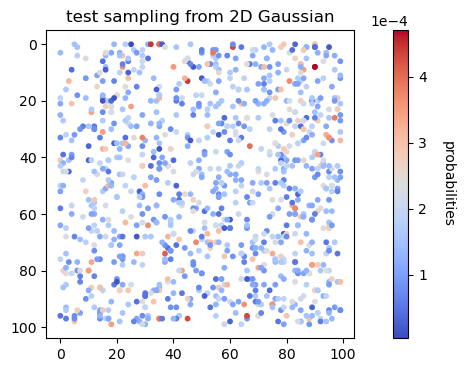

In [80]:
# TESTING EXAMPLE IN DOCSTRING
doctest.testmod();

### Preprocessing image

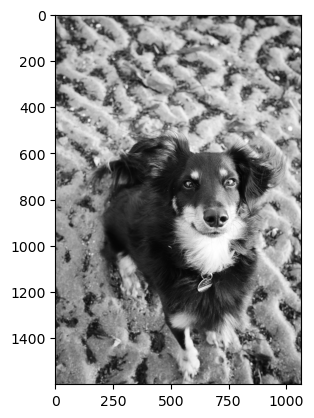

In [40]:
image=Image.open('./img/Eddie.jpeg')

# CONVERT TO GRAYSCALE
gray_image=image.convert('L')

# CONVERT TO np.array
gray_image_array = np.asarray(gray_image)

# NORMALISE
gray_image_array = gray_image_array/gray_image_array.max()

plt.imshow(gray_image_array,cmap='gray')
plt.show()

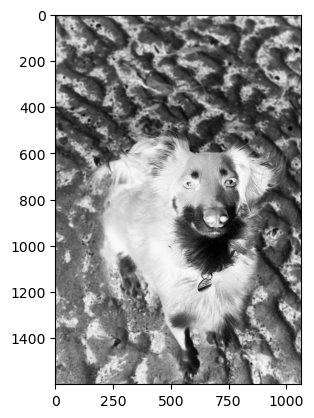

In [89]:
# WANT DARKER PIXELS TO HAVE HIGHER PROBABILITIES 
eddie = 1-gray_image_array # in gray scale image, 0 = black, 1 = white
plt.imshow(eddie,cmap='gray')

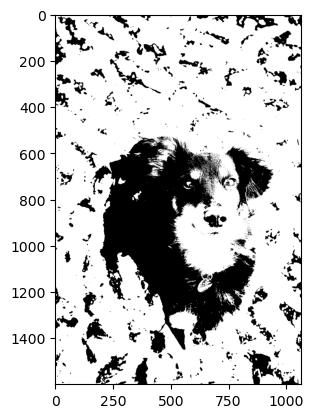

In [91]:
# OPTIONAL: THRESHED IMG
thresh = 0.3
thresh_img = gray_image_array.copy()
thresh_img = np.where(thresh_img > thresh,0,1)
plt.imshow(thresh_img,cmap='gray_r')

### Sampling image

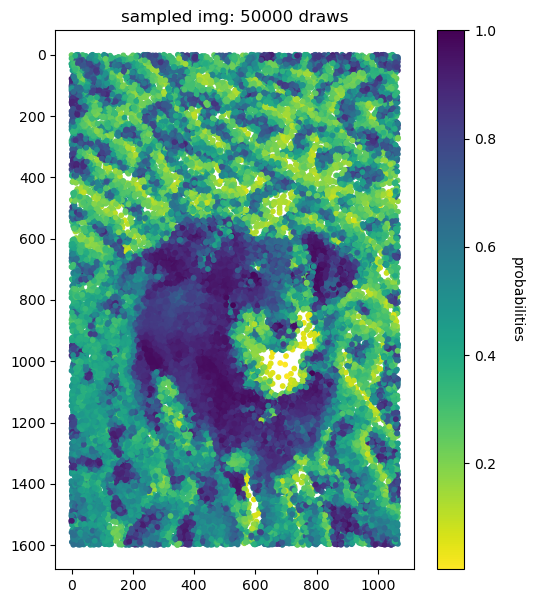

In [88]:
N = 50_000
sample(eddie,n_draws=N,figsize=(6,7),dot_size=10,cmap='viridis_r',title=f'sampled img: {N} draws')

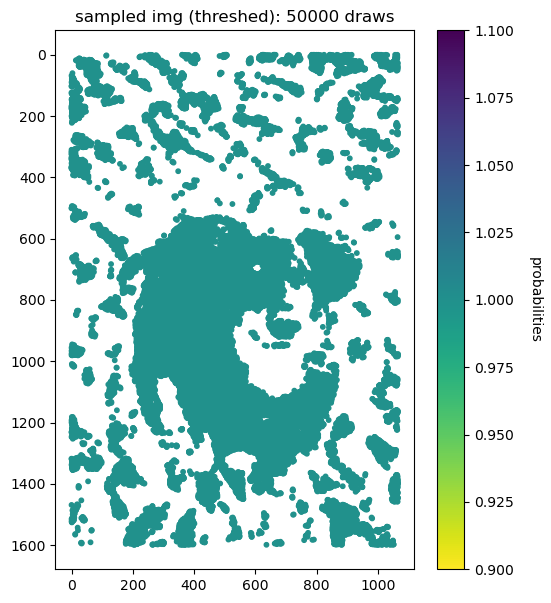

In [86]:
N = 50_000
sample(thresh_img,n_draws=N,figsize=(6,7),dot_size=10,cmap='viridis_r',title=f'sampled img (threshed): {N} draws')